In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map
        
data_2008 = "./200811.csv"
data_2016 = "./20161108.export.CSV"

# Introduction

In this report we're going to take a look at a small sample of the data from the Global Data on Events, Location and Tone project, also known as GDELT. GDELT provides data on global events, storing such things as the type of the event, the actors involved, the location and the tone of documents that report on the event. It thus provides an abstract and data driven view of the world's affairs. It has been in operation since 2013, and has data available from January 1, 1979 to the present. 

For our sample of the GDELT data, we're going to take a look at the data available for the USA's presidential election days in 2008 and 2016: November 4th, 2008 and November 8th, 2016. Of the data GDELT provides, we will focus our analysis on the AvgTone column, which aggregates the average tone of documents talking about the event which has been recorded in the data. As discussed in the GDELT documentation, this can give an overall tone of the narrative that has developed around an event. 

Most observers of USA politics can note significant differences between the 2008 and 2016 election years. Our goal is to determine whether the average tone of media coverage was significantly different between the two election days for those years. Thus, we may be able to express quantitatively what is widely felt, that the election of 2016 was of a different character all together than 2008. Given our limited perspective in this report, strong statistical conclusions are not drawn. However, a more indepth report could seek to build on this to determine exactly in what ways 2016 was different than 2008, and how it compares to past election years as well. 

# Data Preparation

The overall GDELT dataset is very large, weighing in at a few TB. Even restricted to the two CSV files for the month of November in 2008 and November 8th in 2016, the data is quite large. We limit our scope to the 2008 data for this section and briefly discuss ways of decreasing dataframe size and improving load performance; the curious reader will discover a more indepth explanation of the process in the appendix.

In [2]:
df_2008_l = pd.read_csv(data_2008, sep='\t', 
                        names=GDELT_columns[:57], nrows=1000)
df_2016_l = pd.read_csv(data_2016, sep='\t', 
                        names=GDELT_columns, nrows=1000)

### Omitting Extraneous Data

The easiest and most obvious way to decrease the size of the loaded dataframes is to omit columns from the data that are not of interest to our analysis. The documentation notes that there are dates expressed differently in four different columns. Thus, we only load one. Additionally there are columns regarding the date the event was added to the record, DATEADDED, and a column regarding a source url, SOURCEURL. These are also omitted.

### Optimizing Data Types

When loading in a dataframe with unspecified dtypes, Pandas makes safe but space inefficient choices for the data. This also means that Pandas would rather allocate more memory than necessary than try to squeeze the values into more limited data types. Thus we can improve upon memory consumption by downcasting columns data types which represent the same kind of values but which do not reserve quite so many bits. For example, for integer columns Pandas will assume a dtype of int64. We can usually downcast this column into one of the smaller integer types like int8, int16, and int32, which use far fewer bits. 

A more complicated transformation is that of turning an object column into a category column. This transformation is useful when the column has a lot of values that repeat. In this case, Pandas can use a trick to save on memory consumption by constructing a dictionary which has integer keys and the repeated values stored as dictionary values. Then the repeated values are covertly replaced by integers in the column. The original values of the column can then be recovered by following the accompanying dictionary pair. 

### Result of Data Preparation

For comparison, we present below the memory consumption of a dataframe containing the first 1000 rows of the 2008 csv before and after our data preparation.

In [3]:
df_2008_l_opti = pd.read_csv(data_2008, sep='\t', 
                             names=GDELT_columns[:57], 
                             usecols=usecols, 
                             dtype=dtype_dict, 
                             parse_dates=['SQLDATE'], nrows=1000)

num_before, str_before = mem_usage(df_2008_l)
num_after, str_after = mem_usage(df_2008_l_opti)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

Before downcast:  1.06 MB
After downcast:  0.68 MB
Percent Decrease 0.36237027791840404


We thus see a respectable 36% decrease in memory consumption from applying these techniques!

# Data Exploration

In [4]:
df_2008 = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], 
                        usecols=usecols, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
df_2016 = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, 
                        usecols=usecols, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])

We now set out on our goal of understanding possible differences in average tone between our two election days of interest. As we're we want to look at the tone in the US, it makes sense that our first task is to filter our dataframes for events that took place in the US. We can use the column ActionGeo_CountryCode to determine the location of an event.

### Country Code

We first look at the values available in the column to make sure there is nothing unexpected, then we filter for US events. 

In [5]:
df_2008['ActionGeo_CountryCode'].unique()

[AF, US, CA, ID, UK, ..., FK, NT, AV, NF, VC]
Length: 241
Categories (240, object): [AF, US, CA, ID, ..., NT, AV, NF, VC]

In [6]:
df_2008_us = df_2008.loc[df_2008['ActionGeo_CountryCode'] == 'US',:].copy()
df_2016_us = df_2016.loc[df_2016['ActionGeo_CountryCode'] == 'US',:].copy()

### Exploring Event Dates

Next, we want to make sure that the events we're looking at took place on the correct date. This task is slightly different for the 2008 and 2016 CSV's due to differences in how GDELT backfilled data for 2008. (The GDELT project was started in 2013.) Whereas our 2016 CSV is meant to be only for November 8th, 2016, the 2008 CSV we're using covers all of November. We'll look at what dates are present in our SQLDATE columns for each dataframe.

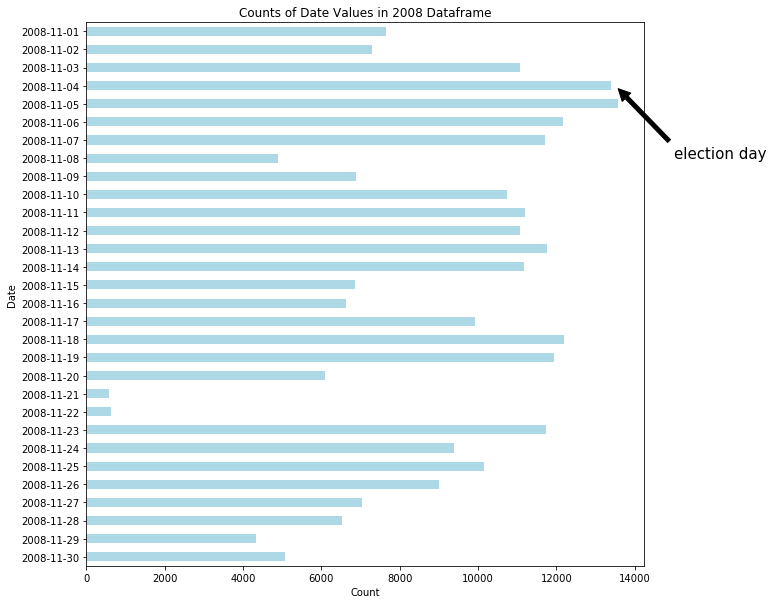

In [7]:
ax = df_2008_us['SQLDATE'].astype(str).value_counts() \
                     .sort_index(ascending=False) \
                     .plot.barh(figsize=(10,10), color='lightblue');
        
ax.annotate('election day', xy=(13500, 26), xytext=(15000, 22), 
            size=15, arrowprops=dict(facecolor='black', shrink=0.05));

plt.ylabel("Date")
plt.xlabel("Count")
plt.title("Counts of Date Values in 2008 Dataframe");

There is a significant uptick in news on and around election day which matches what we would expect. We also do not see any unexpected dates in this 2008 dataframe. 

Now we look at the 2016 dataframe.

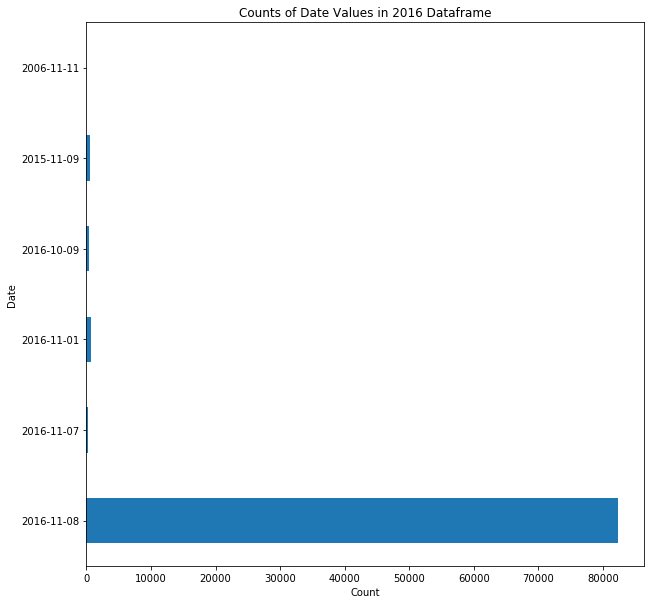

In [8]:
df_2016_us['SQLDATE'].astype(str).value_counts() \
                     .sort_index(ascending=False) \
                     .plot.barh(figsize=(10,10));

plt.ylabel("Date")
plt.xlabel("Count")        
plt.title("Counts of Date Values in 2016 Dataframe");

And we note that there are anomalous dates present in the 2016 CSV.There's at least one 2006 date where appears to be a typo, as well as a 2015 date thrown in this dataset. This indicates we should be sure to filter our 2016 dataset for date as well. 

In [9]:
election_day_2008 = np.datetime64('2008-11-04')
df_2008_usel = df_2008_us.loc[df_2008_us['SQLDATE'] == election_day_2008,:] \
                         .copy()
    
election_day_2016 = np.datetime64('2016-11-08')
df_2016_usel = df_2016_us.loc[df_2016_us['SQLDATE'] == election_day_2016,:] \
                         .copy()

### AvgTone 

We can now start looking at the column of interest we set out to explore, AvgTone. First, let's get an idea of the range of values for our dataframes and see if any difference jumps out at us.

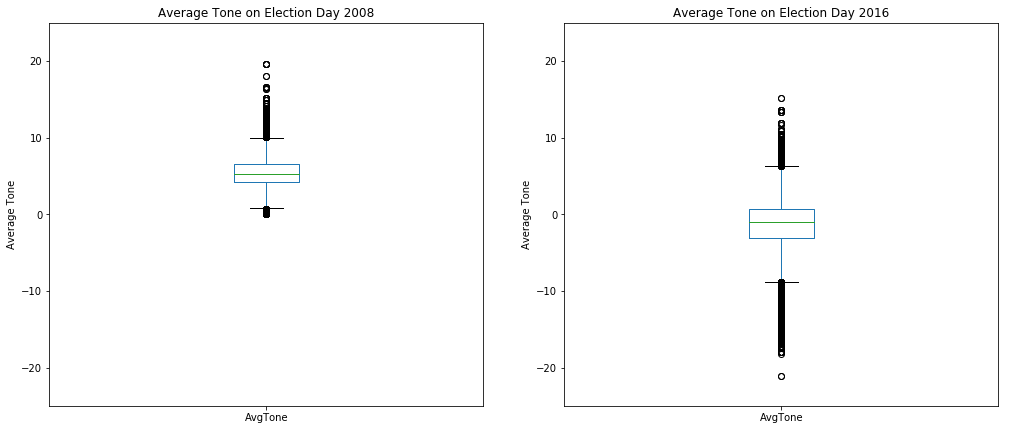

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.tight_layout(pad=5)

plt.subplot(1,2,1)
df_2008_usel['AvgTone'].plot(kind='box')
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2008")

plt.subplot(1,2,2)
df_2016_usel['AvgTone'].plot(kind='box')
plt.ylim(-25, 25)
plt.ylabel("Average Tone")
plt.title("Average Tone on Election Day 2016");

We notice right away that the tone of news stories coming out in 2008 was substantially higher and with far fewer variance than what was being seen in 2016. This already provides some evidence for what we set out to explore.

### AvgTone by State

We can break this down further and attempt to understand the tone of news stories reporting on actions in particular states.  To do this, we'll first have to dig a little deeper into the data and look at the ActionGeo_ADM1Code column which codes more specified location information.

In [11]:
df_2008_usel['ActionGeo_ADM1Code'].unique()

[USDC, USMD, US, USMO, USOR, ..., USRI, USDE, USWI, USAR, USWY]
Length: 53
Categories (53, object): [USDC, USMD, US, USMO, ..., USDE, USWI, USAR, USWY]

We see that the codes for US states are provided in the format of US followed by the 2 letter state code, provided that the event was able to be localized down to the state level. state_dict has already been defined in our GDELT_utils.py to map the codes to the state name. We use it to rename our indices and present the mean AvgTone as grouped by state.

In [12]:
avgtone_2008 = df_2008_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2008_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)
        
avgtone_2016 = df_2016_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
            .mean()[np.sort(df_2016_usel['ActionGeo_ADM1Code'].unique())] \
            .rename(state_dict)

We first show it on a line graph to give a general impression of the difference of AvgTone across the board between the two election years.

In [13]:
avgtone_2008.index

Index(['National', 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland', 'Maine',
       'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 'Montana',
       'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire',
       'New Jersey', 'New Mexico', 'Nevada', 'New York', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Vermont', 'Washington', 'Wisconsin', 'West Virginia',
       'Wyoming'],
      dtype='object', name='ActionGeo_ADM1Code')

In [14]:
std_2008 = df_2008_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
        .std()[np.sort(df_2008_usel['ActionGeo_ADM1Code'].unique())] \
        .rename(state_dict)
std_2016 = df_2016_usel.groupby('ActionGeo_ADM1Code')['AvgTone'] \
        .std()[np.sort(df_2016_usel['ActionGeo_ADM1Code'].unique())] \
        .rename(state_dict)

plt.figure(figsize=(20,15))
plt.scatter(avgtone_2008.index, avgtone_2008, 
            label="Election Day 2008", color="g")
plt.errorbar(avgtone_2008.index, avgtone_2008, 
             yerr=std_2008, alpha=0.3, fmt="o",
             label="Election Day 2008 Standard Deviation", color="green",
             capsize=5)

plt.scatter(avgtone_2016.index, avgtone_2016, 
         label="Election Day 2016", color="r")
plt.errorbar(avgtone_2016.index, avgtone_2016, 
             yerr=std_2016, alpha=0.3, fmt="o",
             label="Election Day 2016 Standard Deviation", color="red",
             capsize=5)

plt.xticks(rotation=90);
plt.ylim(-4.5, 8)
plt.legend(loc=(1,0))
plt.xlabel("State")
plt.ylabel("Average Tone")
plt.title("Mean AvgTone by State on Election Day 2008 and 2016");

ValueError: could not convert string to float: 'Wyoming'

ValueError: could not convert string to float: 'Wyoming'

Finally we show a US heatmap to provide a better means of identifying unique states and variance in between the states.

In [ ]:
state_heat_map(avgtone_2008, -4.5, 8, 
               'Average Tone of Media on Election Day 2008');

In [ ]:
state_heat_map(avgtone_2016, -4.5, 8, 
               'Average Tone of Media on Election Day 2016');

# Conclusion

We set out in this exploration to understand whether we could see a significant difference in the average tone of the documents that discuss events taking place in the USA. These last two heatmaps in particular show that this difference in tone appears to extend across all states and was not localized to parts of the country. Thus, it seems very likely that there is a statistically significant shift in tone in the 8 years. There are a myriad of things that might be behind this, and it would be worthwhile to dig deeper into the data to see what similarities can be found between the years. 

Were the events simply drastically different or had the tone itself changed due to differences in reporting/media agencies?

Does this have something to do with other known sociological effects that may have happened in the interim 8 years, perhaps shifts in the partisan landscape of media?

Was the nature of political rhetoric used in the 2016 election what caused such a shift? Was there a more sudden shift when the 2016 election season began, or was there a steady trend over the last 8 years?

It's not at all clear what might cause such a drastic shift, especially since 2008 was in the midst of the last recession, and it should prove interesting to dig deeper into this and find out what happened. 

# References and Data Sources

### Data Sources
https://www.gdeltproject.org/data.html

http://data.gdeltproject.org/events/200811.zip
    
http://data.gdeltproject.org/events/20161108.export.CSV.zip

### Data Documentation
http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf

### Code References
https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py
    
https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
    
https://www.dataquest.io/blog/pandas-big-data/ 

# Appendix: Indepth Data Preparation

We first load in row limited samples of our two datasets. Our first step is to quickly verify everything looks normal.

In [ ]:
data_2008 = "./200811.csv"
data_2016 = "./20161108.export.CSV"

df_2008_l = pd.read_csv(data_2008, sep='\t', nrows=1000)
df_2016_l = pd.read_csv(data_2016, sep='\t', nrows=1000)

df_2016_l.head()

### Fixing Column Names

We already have a problem! The CSV's do not provide a header. With the documentation, we can determine that there are 58 columns for data after April 2013, and 57 before. With this, we can reload our dataframes properly.

In [ ]:
df_2008_l = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], 
                        nrows=1000)

df_2016_l = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, 
                        nrows=1000)

### Improving Memory Consumption and Performance

By default, Pandas makes safe but space inefficient choices for data types by always defaulting to int64/float64/object. We can improve memory use and load performance when making a dataframe out of the full CSV's by omitting any extra data that we are not interested in for our current analysis and, more importantly, by determining optimized data types for each column.

For the former case, we note by looking at the [Data Format Codebook](http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf) that there are multiple columns which encode dates in different ways. There are also DATEADDED and SOURCEURL fields, describing the date the record was added to the data set and the source of the news respectively, which will not have any bearing on our analysis. Thus we omit these columns. 

Next we look into appropriate data types for our columns. For this analysis we follow the lead of [Using pandas with large data](https://www.dataquest.io/blog/pandas-big-data/). We first filter our dataframes for particular classes of types: integers/floats/objects. For the purposes of this report, we only follow the work on a single dataframe but the analysis has been applied to both.

### Optimizing Number Columns

In [ ]:
df_2008_l_int = df_2008_l.select_dtypes(include=['int64'])
df_2008_l_int.columns

We can then attempt to apply "downcasting" to these integer columns. That is, we can use a method of Pandas, to_numeric, to find the smallest size integer type which will support all values of the columns. The available types are int8, int16, int32 and int64, as well as unsigned variants (only positive numbers) uint8, uint16, uint32 and uint64. The numbers at the end of each type indicate the number of bits consumed in order to represent the data type, and thus smaller numbers correspond with less memory consumption. 

The data's documentation also reaveals that all of these columns will have positive values. (We also find that some of these fields are not best represented as integers for the purposes of analysis, more on this below.) We now apply the downcasting into unsigned integer data types and show a comparison of memory usage.

In [ ]:
converted_int = df_2008_l_int.apply(pd.to_numeric,downcast='unsigned')

num_before, str_before = mem_usage(df_2008_l_int)
num_after, str_after = mem_usage(converted_int)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

We see a 72% decrease in memory usage in this example. A similar process to the one we just applied to int columns can be used for float columns. 

### Optimizing Object Columns

Optimizing object columns is more involved. Generally an object column is made up of string values. In some cases, there is nothing we can do to minimize memory consumption. This generally applies when there are many unique string values in a column. However, if there are sufficient repeats, we can use a different numpy data type known as a category. 

This data type leverages a map-like structure to translate repeated strings into less memory intensive integers, and then covertly replaces the repeated values with these integers. The original values are then recoverable in this case by following the mapping. This can result in huge increases in memory efficiency. For a first pass, we apply a methodology present in our source for this memory optimization which replaces an object column with category if less than 50% of the values are unique.

In [ ]:
df_2008_l_obj = df_2008_l.select_dtypes(include=['object'])
df_2008_l_obj.columns

In [ ]:
converted_obj = pd.DataFrame()

# Credit to https://www.dataquest.io/blog/pandas-big-data/
for col in df_2008_l_obj.columns:
    num_unique_values = len(df_2008_l_obj[col].unique())
    num_total_values = len(df_2008_l_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_2008_l_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_2008_l_obj[col]
        
num_before, str_before = mem_usage(df_2008_l_obj)
num_after, str_after = mem_usage(converted_obj)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

### Test Final Optimized Dataframe

We now collate the information revealed by these naive data type passes as well as our knowledge of the documentation to arrive at our final data types for the columns we wish to investigate.

In [ ]:
df_2008_l_opti = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'], nrows=1000)
df_2016_l_opti = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, \
                        usecols=usecols, dtype=dtype_dict, \
                        parse_dates=['SQLDATE'], nrows=1000)

num_before, str_before = mem_usage(df_2008_l)
num_after, str_after = mem_usage(df_2008_l_opti)

print("Before downcast: ", str_before)
print("After downcast: ", str_after)
print("Percent Decrease", 1 - num_after / num_before)

In the end, with optimized data type choices that also take into consideration the type of analysis we wish to perform, we have a 36% reduction in memory usage for our limited samples. And note we can expect the memory savings to be even greater for the full data frames assuming we chose our category columns correctly!

# Appendix: AvgTone Boxplot by State

In [ ]:
df_2008_usel['ActionGeo_ADM1Code'] = df_2008_usel.loc[:,'ActionGeo_ADM1Code'] \
                                    .cat.remove_unused_categories()
df_2008_usel['ActionGeo_ADM1Code_Readable'] = df_2008_usel.loc[:,'ActionGeo_ADM1Code'] \
                                    .apply(lambda x:state_dict[x])

In [ ]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df_2008_usel,
            x='AvgTone', y='ActionGeo_ADM1Code_Readable')
plt.axvline(df_2008_usel['AvgTone'].median(), linewidth=5, alpha=0.5)
plt.xticks(rotation=90);

# Appendix: Set CSS Style

In [ ]:
# CSS from https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()